# **Sales forecasting of Corporation Favorita Stores using Time Series Regression.**

## **Objective:** 
### To develop a predictive model for store sales for Corporation Favorita, a large grocery retailer headquartered in Ecuador. The model aims to predict the unit sales of numerous items across various Favorita stores, enabling more precise estimation of sales performance.

## Hypotheses for testing:
Hypothesis 1: <br>
```Null```: The promotional activities, oil prices, and holidays/events do not have a significant impact on store sales for Corporation Favorita.<br>
```Alternate```: The promotional activities, oil prices, and holidays/events have a significant impact on store sales for Corporation Favorita.

Hypothesis 2: <br>
```Null```: Sales increase over time. <br>
```Alternate```: Sales dont increase with time.

Hypothesis 3: <br>
```Null```: Situating a startup in a particular city does not influence funding.<br>
```Alternate```: Situating a startup in a particular city significantly affects funding.

### Hypothesis 4: <br>
```Null```: The more the transactions the higher the sales. <br>
```Alternate```: Transactions don't have an impact on sales.



### **Import packages**

In [417]:
# Data Handling
import pyodbc
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from scipy import stats
from dotenv import dotenv_values


# Statistical Analysis
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import ttest_ind
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA


# Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px
from matplotlib.dates import MonthLocator


# Other Packages
import warnings

warnings.filterwarnings("ignore")

## **1. Data Acquistion**

In [418]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')


# Get the values for the credentials you set in the '.env' file
database = environment_variables.get("database")
server = environment_variables.get("server")
username = environment_variables.get("user")
password = environment_variables.get("password")


connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"



In [419]:
# Use the connect method of the pyodbc library and pass in the connection string.
# This will connect to the server and might take a few seconds to be complete. 
# Check your internet connection if it takes more time than necessary

connection = pyodbc.connect(connection_string)

In [420]:
# Define SQL queries for each table
query1 = 'SELECT * FROM dbo.oil'
query2 = 'SELECT * FROM dbo.holidays_events'
query3 = 'SELECT * FROM dbo.stores'

# Read data from tables into pandas DataFrames
oil = pd.read_sql(query1, connection)
holidays_events = pd.read_sql(query2, connection)
stores = pd.read_sql(query3, connection)

# Close the database connection
connection.close()

In [421]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


 <div class="alert alert-block alert-danger" style ="background-color : #e6ebef;">
    <h4 style="padding: 15px;
              color:black;">📌 Renaming the type in holiday data to holiday type
    </h4>
  </div>

In [422]:
holidays_events.head()
holidays_events.rename(columns={
    'type': 'holiday_type'
}, inplace=True)

# Print the resulting DataFrame
holidays_events

,date,holiday_type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


Rename type here as holiday type and concat with oil['dailyoilprices']

In [423]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [424]:
''' sample_submission = pd.read_csv('data/sample_submission.csv')
sample_submission.head() ''' 

" sample_submission = pd.read_csv('data/sample_submission.csv')\nsample_submission.head() "

Do away with this set since sales has no values.

In [425]:
transactions = pd.read_csv('data/transactions.csv')
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [426]:
train = pd.read_csv('data/train.csv')
train.sample(5)

,id,date,store_nbr,family,sales,onpromotion
260475,260475,2013-05-27,18,CELEBRATION,0.0,0
1766236,1766236,2015-09-21,17,EGGS,234.0,13
526362,526362,2013-10-23,28,GROCERY I,1918.0,0
360480,360480,2013-07-22,23,LINGERIE,1.0,0
887664,887664,2014-05-15,15,PRODUCE,0.0,0


In [427]:
train[(train['sales'] == 770) & (train['store_nbr'] == 25) ]

,id,date,store_nbr,family,sales,onpromotion
250053,250053,2013-05-21,25,GROCERY I,770.0,0
417552,417552,2013-08-23,25,BEVERAGES,770.0,0
631396,631396,2013-12-21,25,CLEANING,770.0,0


...

In [428]:
# oil.to_csv('data/oil.csv',index=False)
# transactions.to_csv('data/transactions.csv',index=False)
# holidays_events.to_csv('data/holidays_events.csv',index=False)
# stores.to_csv('data/stores.csv',index=False)

## Join Tables

### Join to display data contained in both dataframes

In [429]:
full_transaction= pd.merge(transactions, train)
full_transaction.sample(5)

,date,store_nbr,transactions,id,family,sales,onpromotion
700536,2014-04-03,49,2223,814023,GROCERY I,4478.0,0
783344,2014-05-28,12,1132,910724,MAGAZINES,0.0,0
17863,2013-01-13,40,1048,22516,EGGS,105.0,0
1715734,2015-12-23,24,4353,1932247,SCHOOL AND OFFICE SUPPLIES,0.0,0
1121643,2014-12-30,45,5276,1295025,CELEBRATION,25.0,0


## Join the full transactions based on stores

In [430]:
result = pd.merge(full_transaction, stores, on='store_nbr', how='inner')
result.head(5)


,date,store_nbr,transactions,id,family,sales,onpromotion,city,state,type,cluster
0,2013-01-01,25,770,561,AUTOMOTIVE,0.0,0,Salinas,Santa Elena,D,1
1,2013-01-01,25,770,562,BABY CARE,0.0,0,Salinas,Santa Elena,D,1
2,2013-01-01,25,770,563,BEAUTY,2.0,0,Salinas,Santa Elena,D,1
3,2013-01-01,25,770,564,BEVERAGES,810.0,0,Salinas,Santa Elena,D,1
4,2013-01-01,25,770,565,BOOKS,0.0,0,Salinas,Santa Elena,D,1


## Join the full transactions based on oil data for each date

In [431]:
result1= pd.merge(result, oil, on='date', how='inner')
result1.sample(5)


,date,store_nbr,transactions,id,family,sales,onpromotion,city,state,type,cluster,dcoilwtico
401915,2014-01-06,26,708,658160,DAIRY,311.000,0,Guayaquil,Guayas,D,10,93.120003
491012,2014-03-27,50,2070,801608,BREAD/BAKERY,329.374,0,Ambato,Tungurahua,A,14,101.250000
187532,2013-06-21,49,1932,306167,PET SUPPLIES,0.000,0,Quito,Pichincha,A,11,93.809998
65624,2013-03-04,9,2318,112253,LAWN AND GARDEN,0.000,0,Quito,Pichincha,B,6,90.129997
985929,2015-06-12,12,1189,1586100,LINGERIE,3.000,0,Latacunga,Cotopaxi,C,15,59.959999


## Join the full transactions based on holidays

In [432]:
salesdata= pd.merge(result1, holidays_events, on='date', how='inner')
salesdata.reset_index(drop=True,inplace=True)
salesdata.head(5)


,date,store_nbr,transactions,id,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,holiday_type,locale,locale_name,description,transferred
0,2013-01-01,25,770,561,AUTOMOTIVE,0.0,0,Salinas,Santa Elena,D,1,NaN,Holiday,National,Ecuador,Primer dia del ano,False
1,2013-01-01,25,770,562,BABY CARE,0.0,0,Salinas,Santa Elena,D,1,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2,2013-01-01,25,770,563,BEAUTY,2.0,0,Salinas,Santa Elena,D,1,NaN,Holiday,National,Ecuador,Primer dia del ano,False
3,2013-01-01,25,770,564,BEVERAGES,810.0,0,Salinas,Santa Elena,D,1,NaN,Holiday,National,Ecuador,Primer dia del ano,False
4,2013-01-01,25,770,565,BOOKS,0.0,0,Salinas,Santa Elena,D,1,NaN,Holiday,National,Ecuador,Primer dia del ano,False


## Drop some columns (id column)

In [433]:
#salesdata.drop(columns='id', inplace=True)

## Rename columns

In [434]:
salesdata.rename(columns={
    'store_nbr': 'store_number',
    'dcoilwtico': 'oil_prices',
}, inplace=True)
salesdata.sample(5)

,date,store_number,transactions,id,family,sales,onpromotion,city,state,type,cluster,oil_prices,holiday_type,locale,locale_name,description,transferred
227397,2016-05-09,51,1590,2177367,PLAYERS AND ELECTRONICS,15.000,0,Guayaquil,Guayas,A,17,43.450001,Event,National,Ecuador,Terremoto Manabi+23,False
177385,2015-12-22,6,2779,1931577,LINGERIE,6.000,0,Quito,Pichincha,D,13,36.119999,Holiday,Local,Salinas,Cantonizacion de Salinas,False
172114,2015-11-30,12,1231,1890820,LADIESWEAR,0.000,0,Latacunga,Cotopaxi,C,15,40.430000,Event,National,Ecuador,Cyber Monday,False
119564,2014-12-31,48,4396,1296905,BREAD/BAKERY,765.695,0,Quito,Pichincha,A,14,53.450001,Additional,National,Ecuador,Primer dia del ano-1,False
268486,2016-12-06,31,1446,2552647,SCHOOL AND OFFICE SUPPLIES,0.000,0,Babahoyo,Los Rios,B,10,50.950001,Holiday,Local,Quito,Fundacion de Quito,False


In [435]:
salesdata.columns

Index(['date', 'store_number', 'transactions', 'id', 'family', 'sales',
       'onpromotion', 'city', 'state', 'type', 'cluster', 'oil_prices',
       'holiday_type', 'locale', 'locale_name', 'description', 'transferred'],
      dtype='object')

In [436]:
salesdata = salesdata[['id','date',  'store_number', 'transactions', 'family', 'sales',
       'onpromotion', 'city', 'state', 'type', 'cluster', 'oil_prices',
       'holiday_type', 'locale', 'locale_name', 'description', 'transferred']]

In [437]:
salesdata.head()

,id,date,store_number,transactions,family,sales,onpromotion,city,state,type,cluster,oil_prices,holiday_type,locale,locale_name,description,transferred
0,561,2013-01-01,25,770,AUTOMOTIVE,0.0,0,Salinas,Santa Elena,D,1,NaN,Holiday,National,Ecuador,Primer dia del ano,False
1,562,2013-01-01,25,770,BABY CARE,0.0,0,Salinas,Santa Elena,D,1,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2,563,2013-01-01,25,770,BEAUTY,2.0,0,Salinas,Santa Elena,D,1,NaN,Holiday,National,Ecuador,Primer dia del ano,False
3,564,2013-01-01,25,770,BEVERAGES,810.0,0,Salinas,Santa Elena,D,1,NaN,Holiday,National,Ecuador,Primer dia del ano,False
4,565,2013-01-01,25,770,BOOKS,0.0,0,Salinas,Santa Elena,D,1,NaN,Holiday,National,Ecuador,Primer dia del ano,False


## **Generate summary statistics and transpose the rows and columns of the resultant DataFrame then trnsposing for a detailed view.**

In [438]:
salesdata.describe().T

,count,mean,std,min,25%,50%,75%,max
id,322047.0,1.682979e+06,786249.257767,561.000000,1010616.50,1.842406e+06,2.209556e+06,3.000887e+06
store_number,322047.0,2.699467e+01,15.595174,1.000000,13.00,2.700000e+01,4.000000e+01,5.400000e+01
transactions,322047.0,1.734118e+03,1050.335018,54.000000,1030.00,1.409000e+03,2.148000e+03,8.359000e+03
sales,322047.0,4.063835e+02,1246.881240,0.000000,1.00,1.900000e+01,2.412605e+02,1.247170e+05
onpromotion,322047.0,3.727136e+00,15.512095,0.000000,0.00,0.000000e+00,1.000000e+00,7.160000e+02
cluster,322047.0,8.531202e+00,4.713809,1.000000,4.00,9.000000e+00,1.300000e+01,1.700000e+01
oil_prices,300003.0,6.407791e+01,25.147682,27.959999,44.66,5.144000e+01,9.474000e+01,1.079500e+02


## **Checking for duplicate rows.**

In [439]:
salesdata.duplicated().sum()

0

 <div class="alert alert-block alert-danger" style ="background-color : #e6ebef;">
    <h4 style="padding: 15px;
              color:black;">📌 There are no duplicate rows!
    </h4>
  </div>

In [440]:
salesdata.to_csv('data/FavoritaStores_Data.csv', index=False)


 <div class="alert alert-block alert-danger" style ="background-color : #e6ebef;">
    <h4 style="padding: 15px;
              color:black;">📌 Data saved to a csv file for further analysis in BI
    </h4>
  </div>

## **2. Univariate Data Analysis**

### **Both histograms and boxplot are plotted to show distributions and any presence of outliers**

>### **2.1. Sales column**



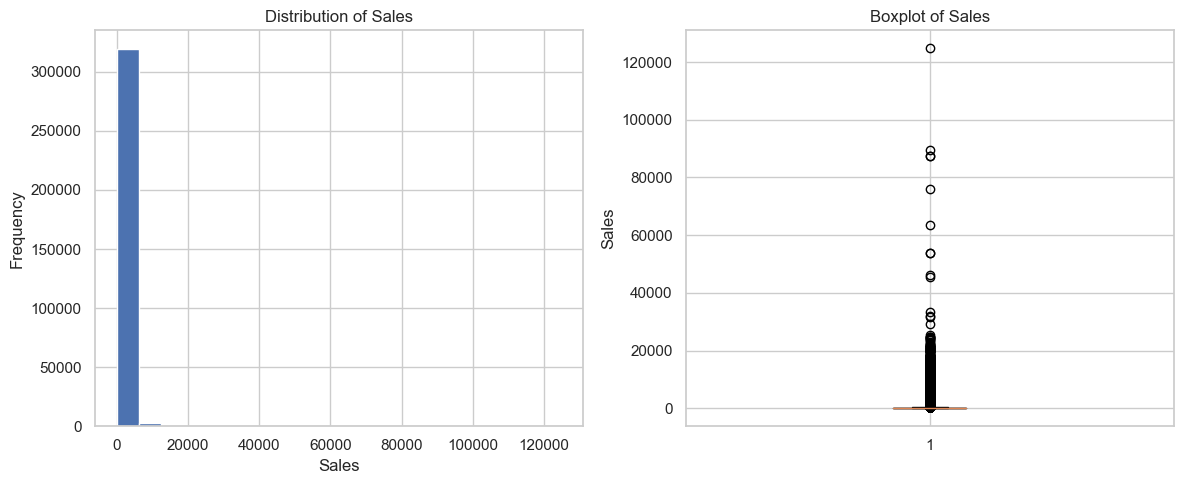

In [441]:
# Create a figure and two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram on the first subplot (ax1)
ax1.hist(salesdata['sales'], bins=20)
ax1.set_xlabel('Sales')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Sales')

# Plot the boxplot on the second subplot (ax2)
ax2.boxplot(salesdata['sales'])
ax2.set_ylabel('Sales')
ax2.set_title('Boxplot of Sales')

# Adjust layout to avoid overlapping labels
plt.tight_layout()

# Show the plots
plt.show()

<div class="alert alert-block alert-danger" style="background-color: #e6ebef;">
    <h4 style="padding: 15px; color: black;">
        📌 The sales are positively skewed thus the median value is closer to the first quartile. The boxplot shows presence of very extreme values thus a high range between the values.
    </h4>
</div>


>### **2.2. Transactions column**



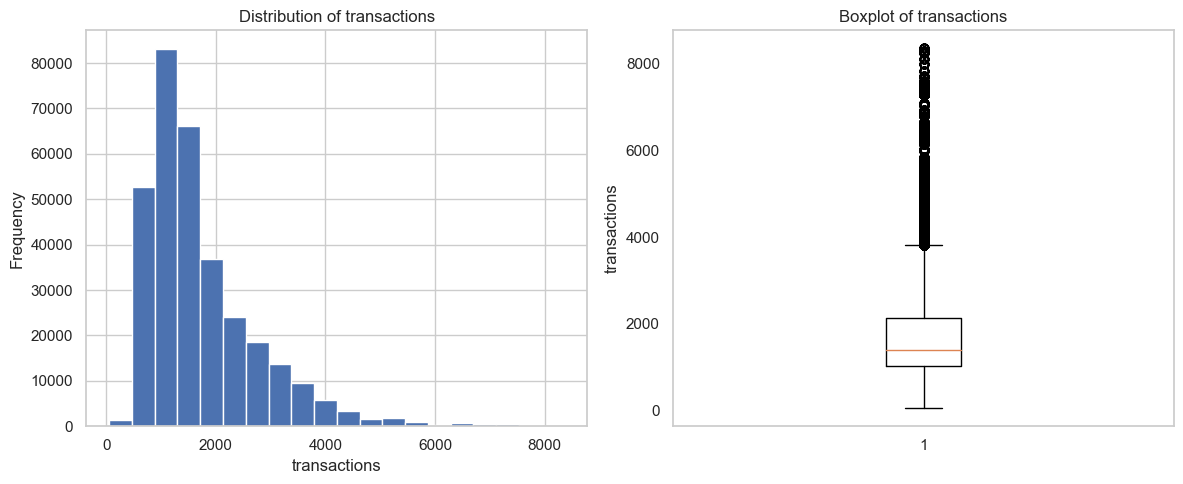

In [442]:
# Create a figure and two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram on the first subplot (ax1)
ax1.hist(salesdata['transactions'], bins=20)
ax1.set_xlabel('transactions')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of transactions')
plt.grid(False)


# Plot the boxplot on the second subplot (ax2)
ax2.boxplot(salesdata['transactions'])
ax2.set_ylabel('transactions')
ax2.set_title('Boxplot of transactions')

# Adjust layout to avoid overlapping labels
plt.tight_layout()

# Show the plots
plt.grid(False)
plt.show()

<div class="alert alert-block alert-danger" style="background-color: #e6ebef;">
    <h4 style="padding: 15px; color: black;">
        📌 The transactions are positively skewed
</div>


>### **2.3. Oil Prices column column**



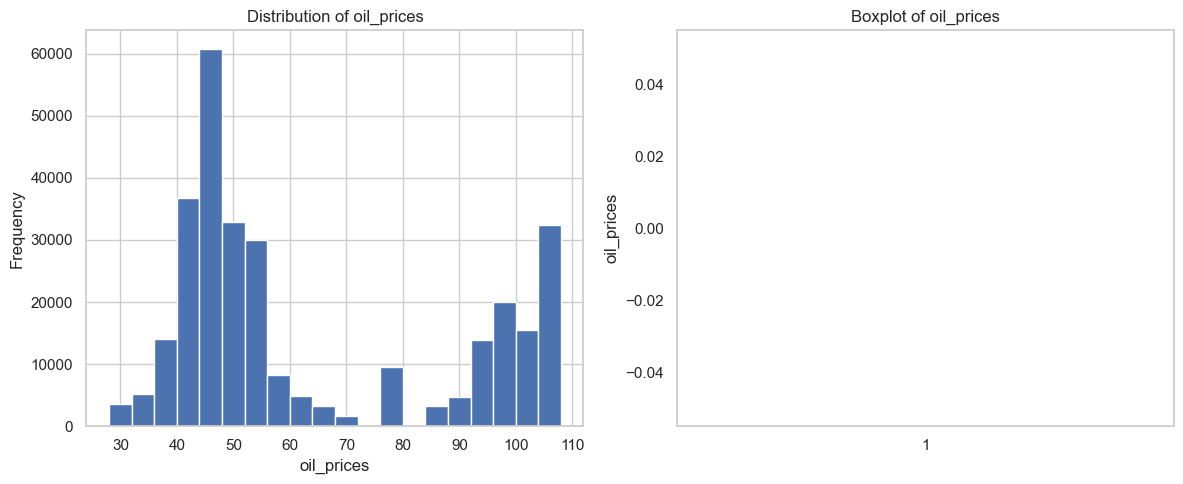

In [443]:
# Create a figure and two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram on the first subplot (ax1)
ax1.hist(salesdata['oil_prices'], bins=20)
ax1.set_xlabel('oil_prices')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of oil_prices')
plt.grid(False)


# Plot the boxplot on the second subplot (ax2)
ax2.boxplot(salesdata['oil_prices'])
ax2.set_ylabel('oil_prices')
ax2.set_title('Boxplot of oil_prices')

# Adjust layout to avoid overlapping labels
plt.tight_layout()

# Show the plots
plt.grid(False)
plt.show()

<div class="alert alert-block alert-danger" style="background-color: #e6ebef;">
    <h4 style="padding: 15px; color: black;">
        📌 Please insert explanation
</div>


>### **2.4. Onpromotion column**



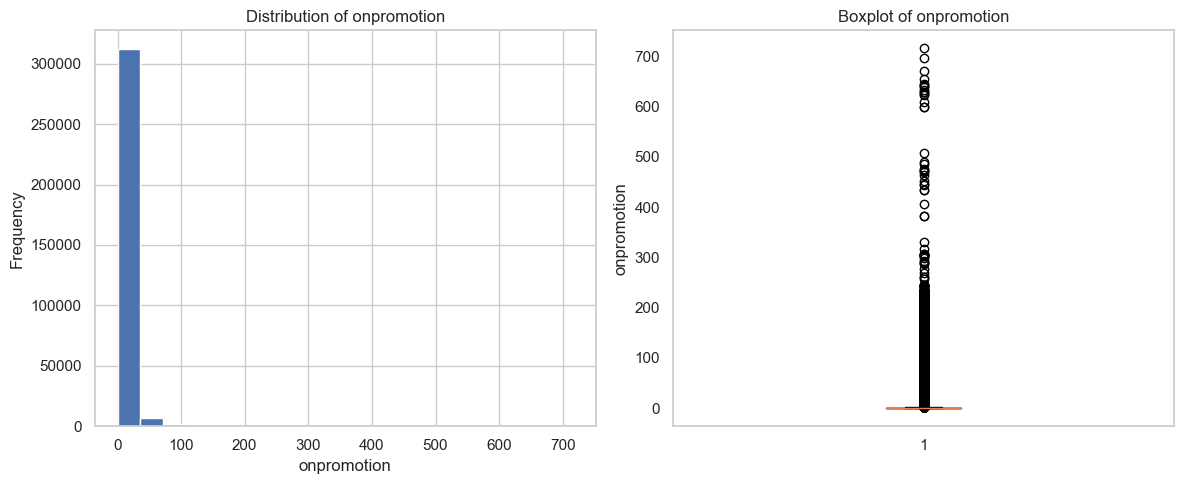

In [444]:
# Create a figure and two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram on the first subplot (ax1)
ax1.hist(salesdata['onpromotion'], bins=20)
ax1.set_xlabel('onpromotion')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of onpromotion')
plt.grid(False)


# Plot the boxplot on the second subplot (ax2)
ax2.boxplot(salesdata['onpromotion'])
ax2.set_ylabel('onpromotion')
ax2.set_title('Boxplot of onpromotion')

# Adjust layout to avoid overlapping labels
plt.tight_layout()

# Show the plots
plt.grid(False)
plt.show()

## **3. Bivariate Data Analysis**

>### **3.1. Trend of Daily average sales**



Text(0.5, 1.0, 'Daily average Sales over Time')

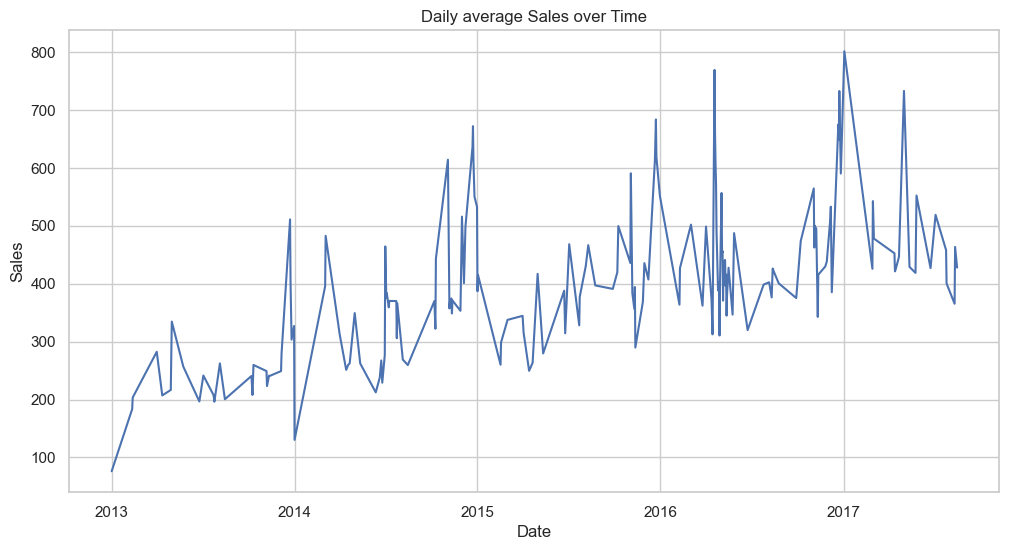

In [445]:
salesdata['date']=pd.to_datetime(salesdata['date'])
salesdata_daily=salesdata.groupby('date')['sales'].mean()
plt.figure(figsize= (12,6))
plt.plot(salesdata_daily.index,salesdata_daily.values)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Daily average Sales over Time')


>### **3.2. Trend of Daily Average Oil Prices**



Text(0.5, 1.0, 'Daily average Oil Prices over Time')

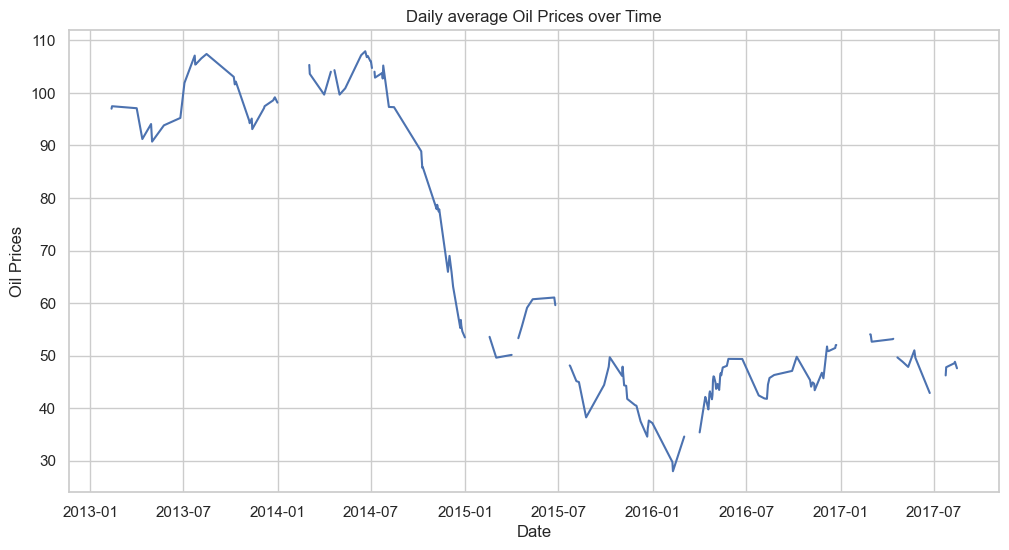

In [446]:
salesdata['date']=pd.to_datetime(salesdata['date'])
salesdata_daily=salesdata.groupby('date')['oil_prices'].mean()
plt.figure(figsize= (12,6))
plt.plot(salesdata_daily.index,salesdata_daily.values)
plt.xlabel('Date')
plt.ylabel('Oil Prices')
plt.title('Daily average Oil Prices over Time')


>### **3.3. Sales against holiday type**



Text(0.5, 1.0, 'Sales count against Holidays')

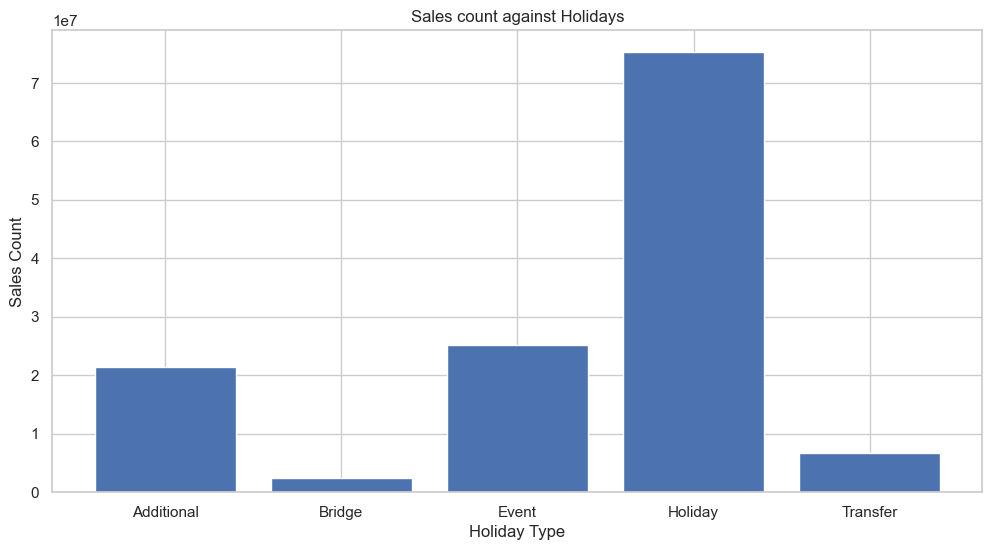

In [447]:
salesdata['date']=pd.to_datetime(salesdata['date'])
salesdata_daily=salesdata.groupby('holiday_type')['sales'].sum()
plt.figure(figsize= (12,6))
plt.bar(salesdata_daily.index,salesdata_daily.values)
plt.xlabel('Holiday Type')
plt.ylabel('Sales Count')
plt.title('Sales count against Holidays')


<div class="alert alert-block alert-danger" style="background-color: #e6ebef;">
    <h4 style="padding: 15px; color: black;">
        📌 There were more sales on holidyas than any other day with the least being a bridge day
</div>


>### **3.3. Sales against store number**



Text(0.5, 1.0, 'Top 10 Sales Count against Store Number')

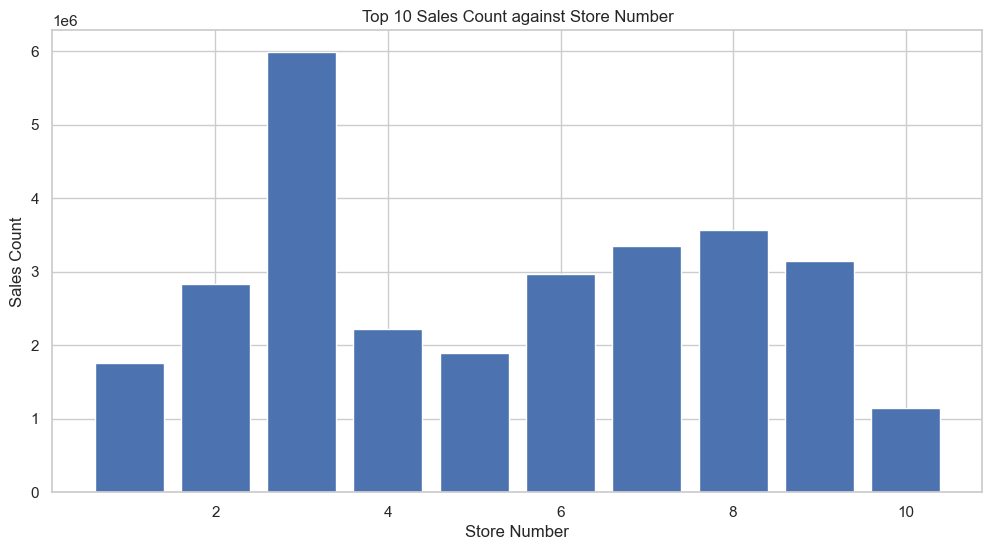

In [448]:
salesdata['date']=pd.to_datetime(salesdata['date'])
salesdata_daily=salesdata.groupby('store_number')['sales'].sum().head(10)
salesdata_daily= salesdata_daily.sort_values(ascending=False)
plt.figure(figsize= (12,6))
plt.bar(salesdata_daily.index,salesdata_daily.values)
plt.xlabel('Store Number')
plt.ylabel('Sales Count')
plt.title('Top 10 Sales Count against Store Number')


Text(0.5, 1.0, 'Bottom 10 Sales Count against Store Number')

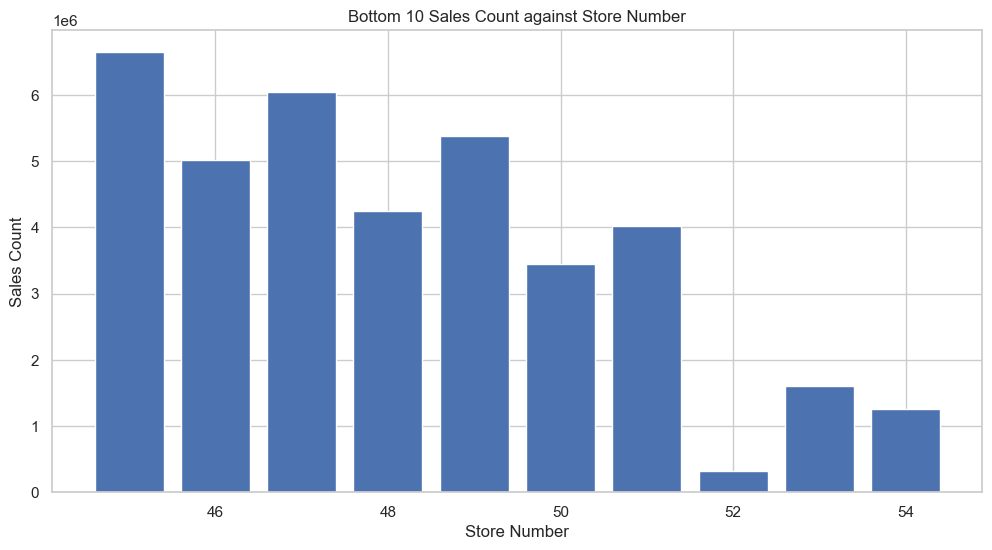

In [449]:
salesdata['date']=pd.to_datetime(salesdata['date'])
salesdata_daily=salesdata.groupby('store_number')['sales'].sum().tail(10)
salesdata_daily= salesdata_daily.sort_values(ascending=False)
plt.figure(figsize= (12,6))
plt.bar(salesdata_daily.index,salesdata_daily.values)
plt.xlabel('Store Number')
plt.ylabel('Sales Count')
plt.title('Bottom 10 Sales Count against Store Number')


<div class="alert alert-block alert-danger" style="background-color: #e6ebef;">
    <h4 style="padding: 15px; color: black;">
        📌 After displaying both the top 10 and bottom 10 most store salers the highest store seller was store number 3 and the bottom store seller being store number 52.
</div>


> ### **3.4 Sales against Product**

Text(0.5, 1.0, 'Top 10 Sales Count against Product Sold')

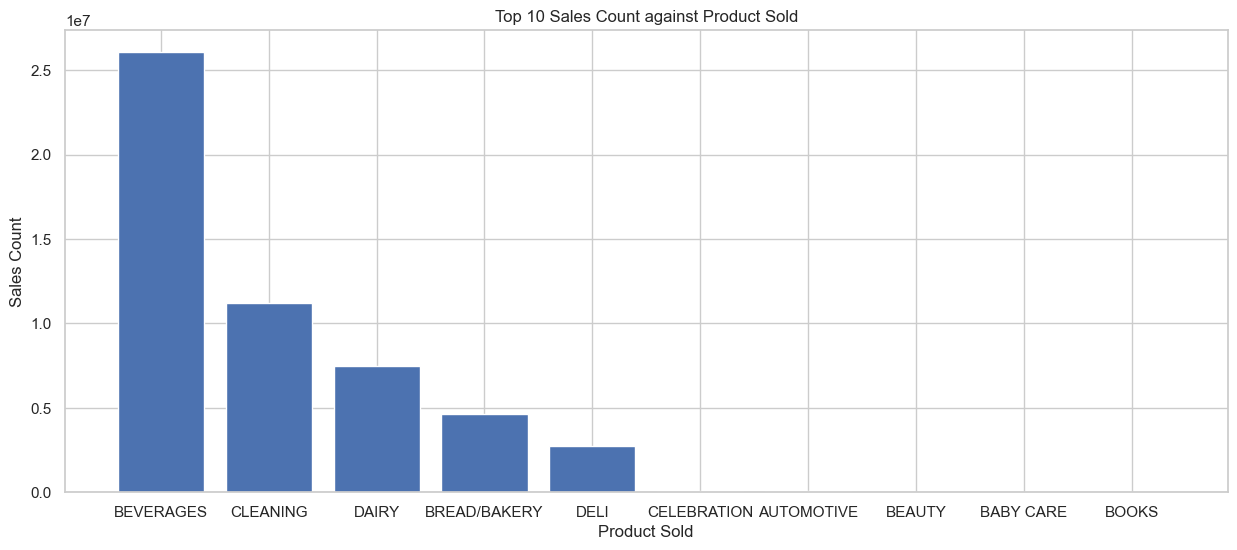

In [450]:
salesdata['date']=pd.to_datetime(salesdata['date'])
salesdata_daily=salesdata.groupby('family')['sales'].sum().head(10)
salesdata_daily= salesdata_daily.sort_values(ascending=False)
plt.figure(figsize= (15,6))
plt.bar(salesdata_daily.index,salesdata_daily.values)
plt.xlabel('Product Sold')
plt.ylabel('Sales Count')
plt.title('Top 10 Sales Count against Product Sold')


<div class="alert alert-block alert-danger" style="background-color: #e6ebef;">
    <h4 style="padding: 15px; color: black;">
        📌 After displaying the top 10 product with most sales beverages were the leading products followed by cleaning products
</div>


> ### **3.5 Sales against State**

Text(0.5, 1.0, 'Top 10 Sales Count against State')

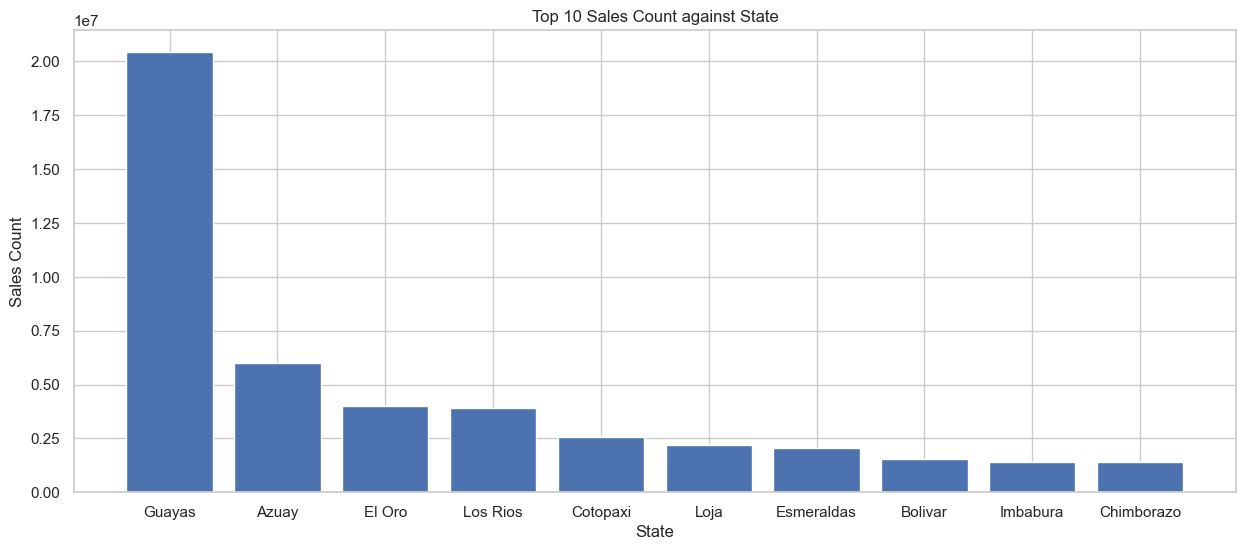

In [451]:
salesdata['date']=pd.to_datetime(salesdata['date'])
salesdata_daily=salesdata.groupby('state')['sales'].sum().head(10)
salesdata_daily= salesdata_daily.sort_values(ascending=False)
plt.figure(figsize= (15,6))
plt.bar(salesdata_daily.index,salesdata_daily.values)
plt.xlabel('State')
plt.ylabel('Sales Count')
plt.title('Top 10 Sales Count against State')


Text(0.5, 1.0, 'Sales Count in Various series in Guayas')

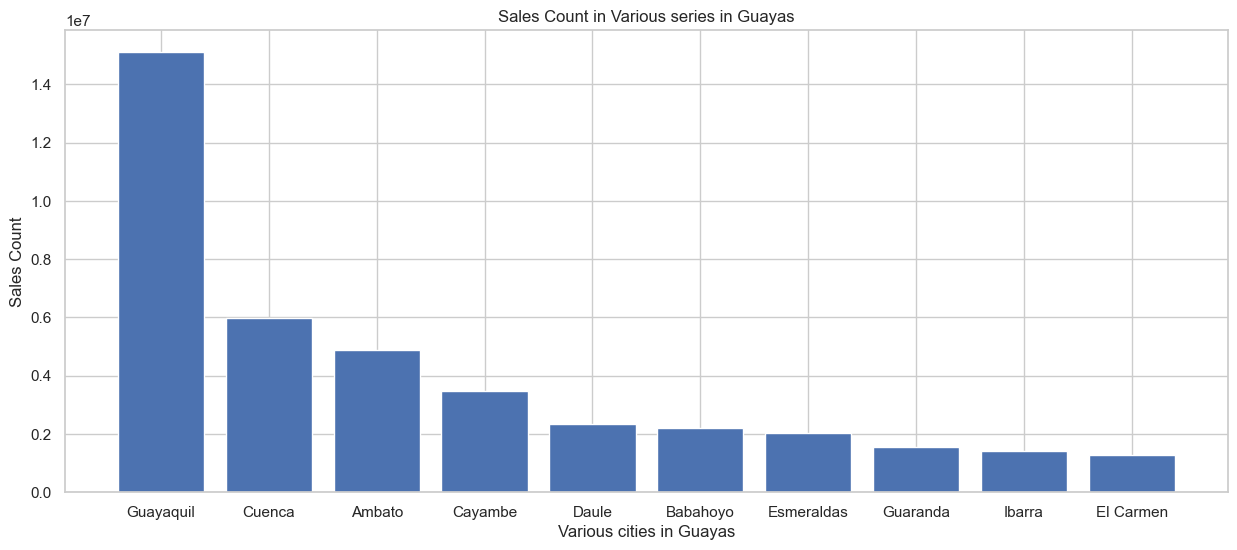

In [452]:
salesdata['date']=pd.to_datetime(salesdata['date'])
salesdata_daily=salesdata[salesdata['state']=='Guayas']
salesdata_daily=salesdata.groupby('city')['sales'].sum().head(10)
salesdata_daily= salesdata_daily.sort_values(ascending=False)
plt.figure(figsize= (15,6))
plt.bar(salesdata_daily.index,salesdata_daily.values)
plt.xlabel('Various cities in Guayas')
plt.ylabel('Sales Count')
plt.title('Sales Count in Various series in Guayas')



<div class="alert alert-block alert-danger" style="background-color: #e6ebef;">
    <h4 style="padding: 15px; color: black;">
        📌 Most sales where recorded in the state of Guayas. Given the state of Guayas the highest city with most sales in Guayas is Guayaquil
</div>


> ### **3.6. Sales against type**

Text(0.5, 1.0, 'Top 10 Sales Count against State')

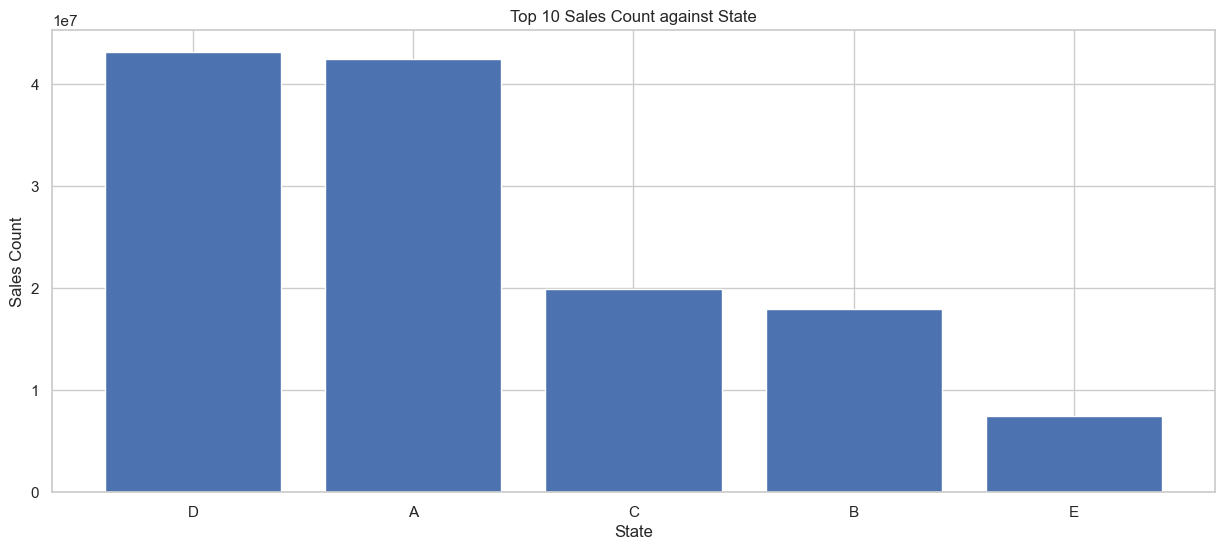

In [453]:
salesdata['date']=pd.to_datetime(salesdata['date'])
salesdata_daily=salesdata.groupby('type')['sales'].sum().head(10)
salesdata_daily= salesdata_daily.sort_values(ascending=False)
plt.figure(figsize= (15,6))
plt.bar(salesdata_daily.index,salesdata_daily.values)
plt.xlabel('State')
plt.ylabel('Sales Count')
plt.title('Top 10 Sales Count against State')


<div class="alert alert-block alert-danger" style="background-color: #e6ebef;">
    <h4 style="padding: 15px; color: black;">
        📌 Most sales where related to product of type D and the least of product type E
</div>


## **4. Time Series Analysis of sales by resampling**

### We visualize the time series of sales across time

In [455]:
# Choose date and sales columns
timeseriesdata=salesdata[['sales','date']]
timeseriesdata.index = timeseriesdata['date']
timeseriesdata
# make date the index
del timeseriesdata['date']
timeseriesdata



,sales
date,
2013-01-01,0.00000
2013-01-01,0.00000
2013-01-01,2.00000
2013-01-01,810.00000
2013-01-01,0.00000
...,...
2016-10-07,253.38101
2016-10-07,43.00000
2016-10-07,281.20200


>### **4.1. Yearly Series of Total Sales**

Text(0, 0.5, 'Sales')

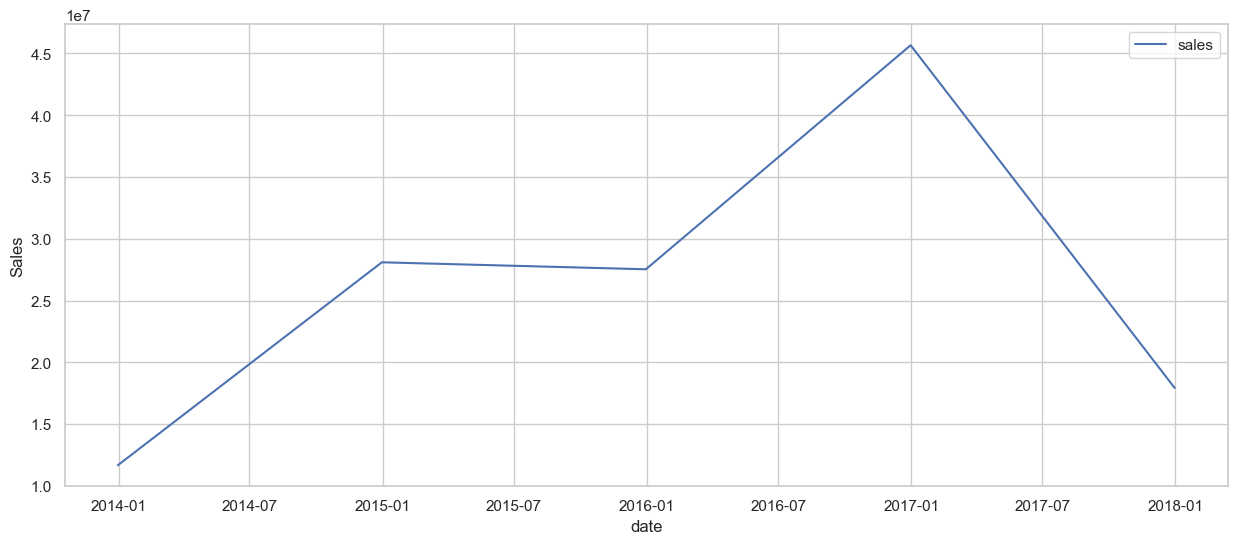

In [509]:
sales_per_year= timeseriesdata.resample('Y').sum()
plt.figure(figsize= (15,6))
sns.lineplot(sales_per_year)
plt.ylabel('Sales')


>### **4.2. Analyzing monthly sales across each year**

In [513]:
timeseriesdata= timeseriesdata.resample('M').sum()



>## **4.2.1. Year 2013**

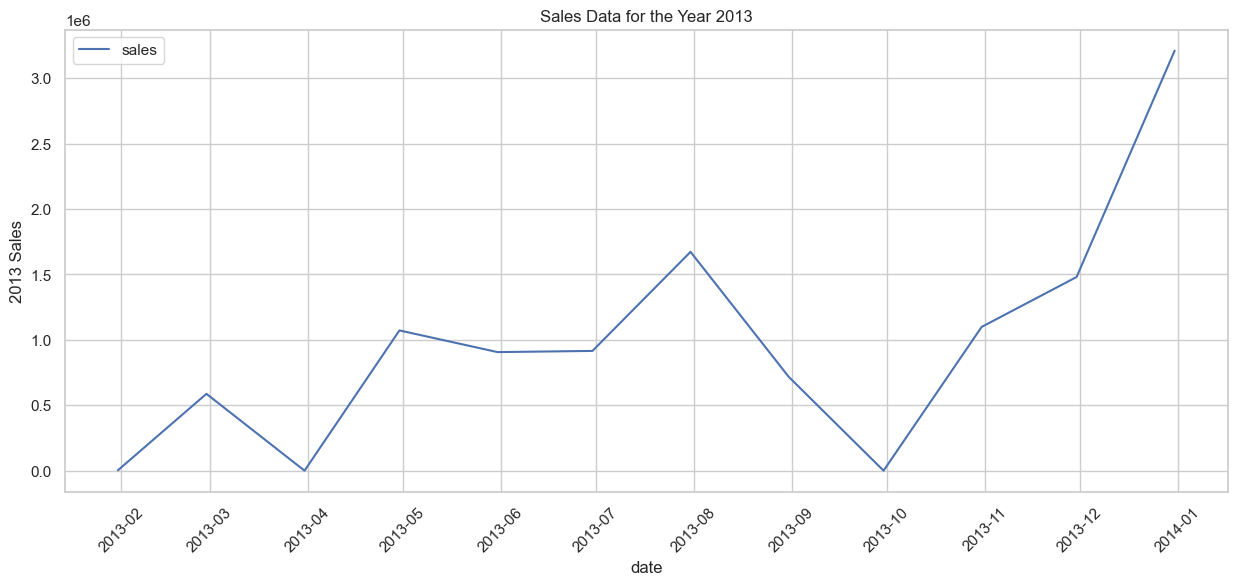

In [514]:
data2013 = timeseriesdata[timeseriesdata.index.year == 2013]
# Set the figure size
plt.figure(figsize=(15, 6))
# Create the line plot using Seaborn
sns.lineplot(data=data2013)
# Set x-axis locator to one-month interval
plt.gca().xaxis.set_major_locator(MonthLocator(interval=1))
plt.ylabel('2013 Sales')
plt.title('Sales Data for the Year 2013')
# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)
# Display the plot
plt.show()



>## **4.2.2. Year 2014**

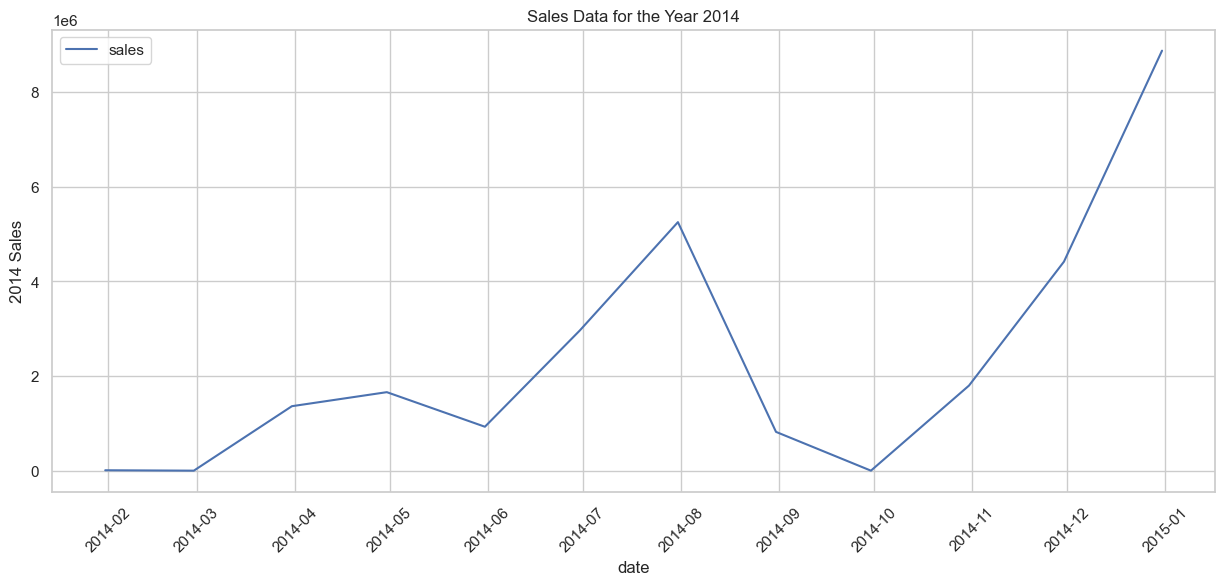

In [515]:
data2014 = timeseriesdata[timeseriesdata.index.year == 2014]
# Set the figure size
plt.figure(figsize=(15, 6))
# Create the line plot using Seaborn
sns.lineplot(data=data2014)
# Set x-axis locator to one-month interval
plt.gca().xaxis.set_major_locator(MonthLocator(interval=1))
plt.ylabel('2014 Sales')
plt.title('Sales Data for the Year 2014')
# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)
# Display the plot
plt.show()



>## **4.2.3. Year 2015**

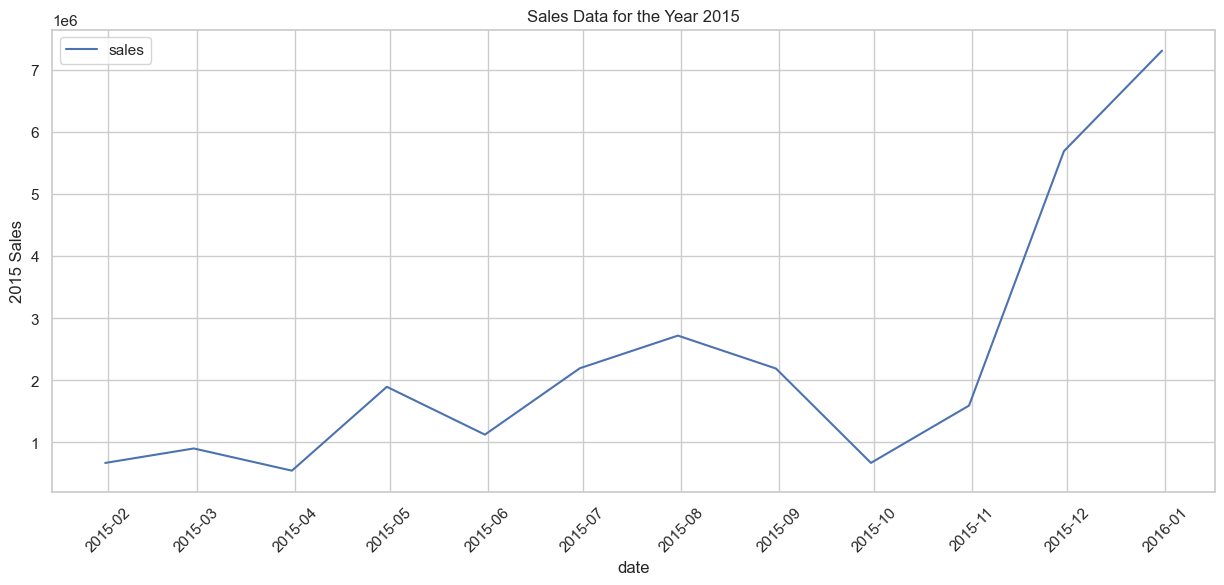

In [516]:
data2015 = timeseriesdata[timeseriesdata.index.year == 2015]
# Set the figure size
plt.figure(figsize=(15, 6))
# Create the line plot using Seaborn
sns.lineplot(data=data2015)
# Set x-axis locator to one-month interval
plt.gca().xaxis.set_major_locator(MonthLocator(interval=1))
plt.ylabel('2015 Sales')
plt.title('Sales Data for the Year 2015')
# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)
# Display the plot
plt.show()



>## **4.2.4. Year 2016**

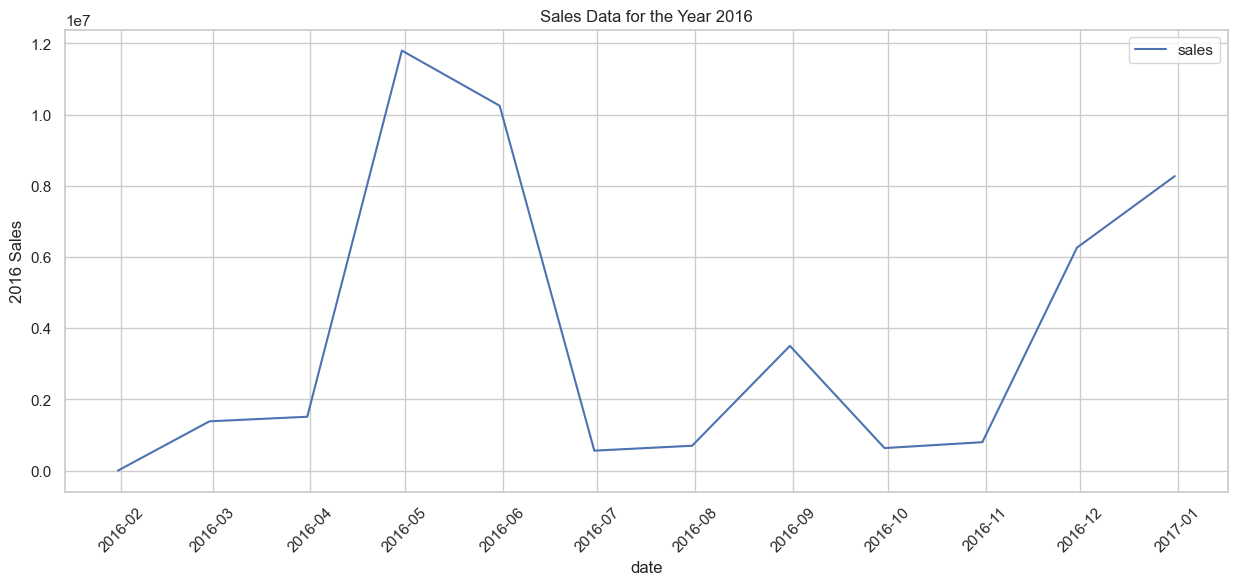

In [517]:
data2016 = timeseriesdata[timeseriesdata.index.year == 2016]
# Set the figure size
plt.figure(figsize=(15, 6))
# Create the line plot using Seaborn
sns.lineplot(data=data2016)
# Set x-axis locator to one-month interval
plt.gca().xaxis.set_major_locator(MonthLocator(interval=1))
plt.ylabel('2016 Sales')
plt.title('Sales Data for the Year 2016')
# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)
# Display the plot
plt.show()



>## **4.2.5. Year 2013**

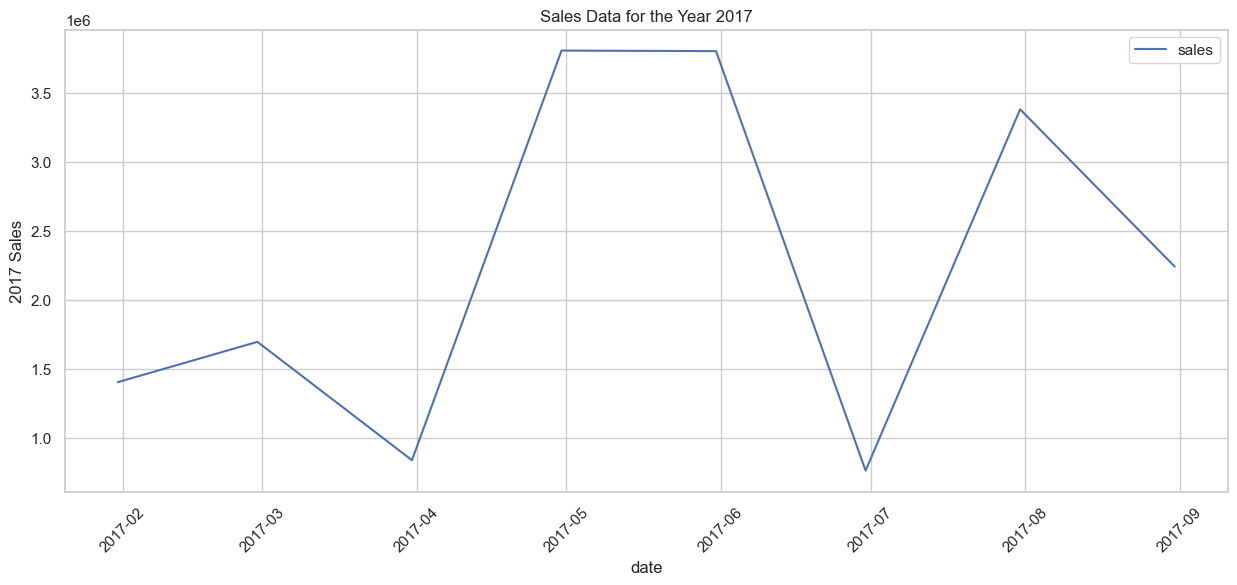

In [518]:
data2017 = timeseriesdata[timeseriesdata.index.year == 2017]
# Set the figure size
plt.figure(figsize=(15, 6))
# Create the line plot using Seaborn
sns.lineplot(data=data2017)
# Set x-axis locator to one-month interval
plt.gca().xaxis.set_major_locator(MonthLocator(interval=1))
plt.ylabel('2017 Sales')
plt.title('Sales Data for the Year 2017')
# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)
# Display the plot
plt.show()



## **4.3. Sales series across months**

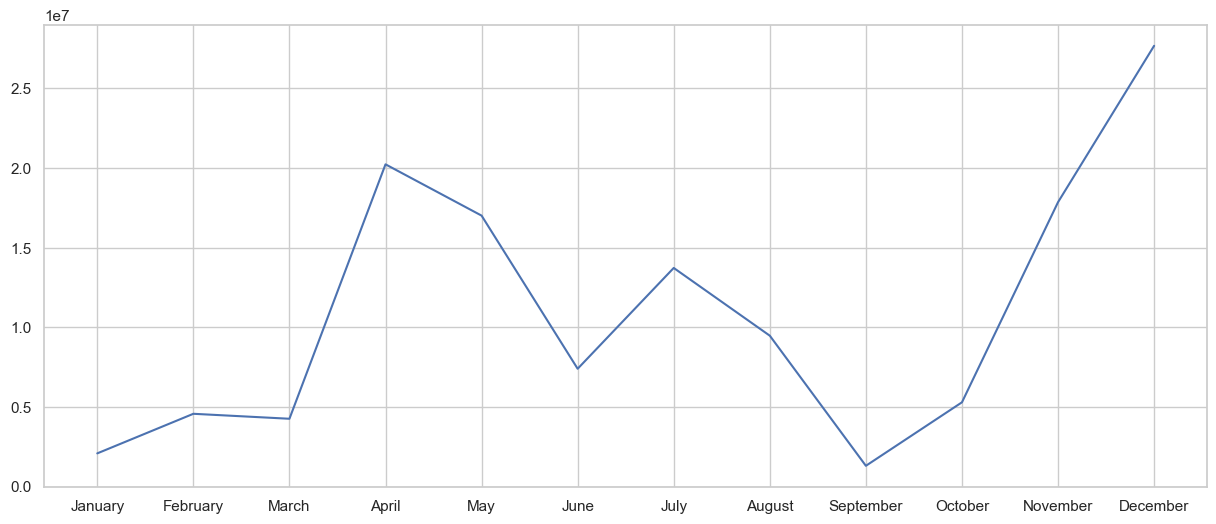

In [524]:

# Group by month and calculate the sum of sales
monthly_sales = salesdata.groupby(salesdata['date'].dt.strftime('%B'))['sales'].sum()
# List of month names in order
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
# Convert month names to categorical with specified order
monthly_sales.index = pd.Categorical(monthly_sales.index, categories=month_order, ordered=True)
# Sort the index to order the months
monthly_sales = monthly_sales.sort_index()
# Set the figure size
plt.figure(figsize=(15, 6))
# Create the line plot using Seaborn
plt.plot(monthly_sales)
plt.show()





<div class="alert alert-block alert-danger" style="background-color: #e6ebef;">
    <h4 style="padding: 15px; color: black;">
        The sales start increasing from september but exponentionally increase from October to December and from March to April. The highest purchases where witnessed in December and the lowest in September.
    </h4>
</div>


## **4.4. Sales Series in Date**

In [539]:
salesdata['date']=pd.to_datetime(salesdata['date'])
daily_sales = salesdata.groupby(salesdata['date'].dt.day)['sales'].sum().reset_index()

# Create a time series plot with slider
fig = px.line(daily_sales, x='date', y='sales')
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(title='Trend of Sales Over Time', title_x=0.5)
fig.show()


<div class="alert alert-block alert-danger" style="background-color: #e6ebef;">
    <h4 style="padding: 15px; color: black;">
        The highest sales are recorded at the beginning and at the end of the month.
    </h4>
</div>


## **Sales Series Quarterly**

Text(0, 0.5, 'Sales')

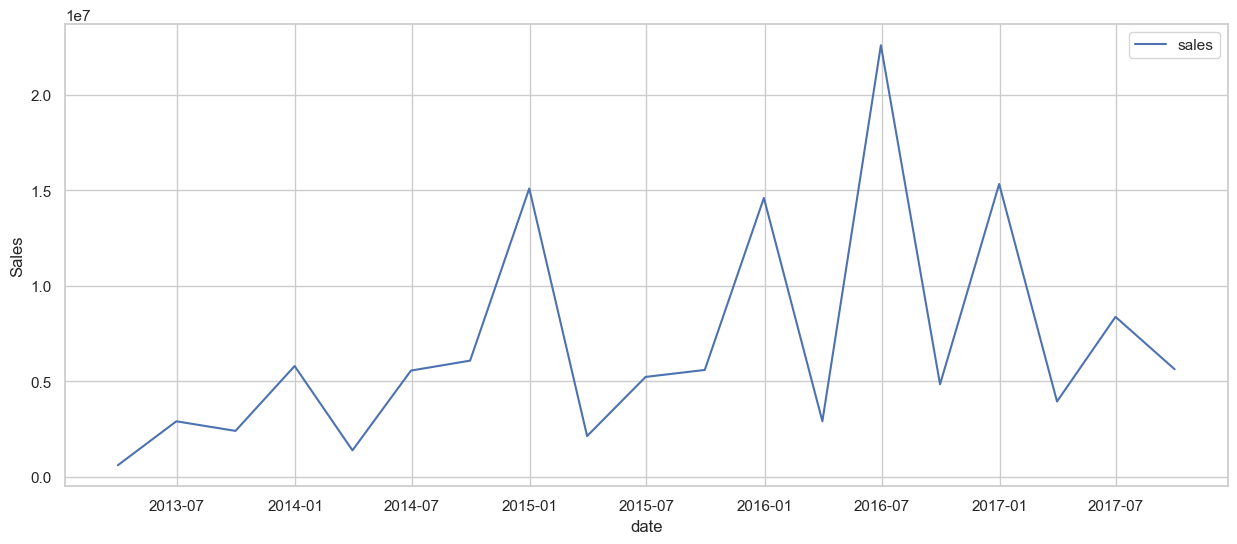

In [542]:
sales_per_quarter=timeseriesdata.resample('Q').sum()
plt.figure(figsize= (15,6))
sns.lineplot(sales_per_quarter)
plt.ylabel('Sales')


>## **MultiVariate Analysis**

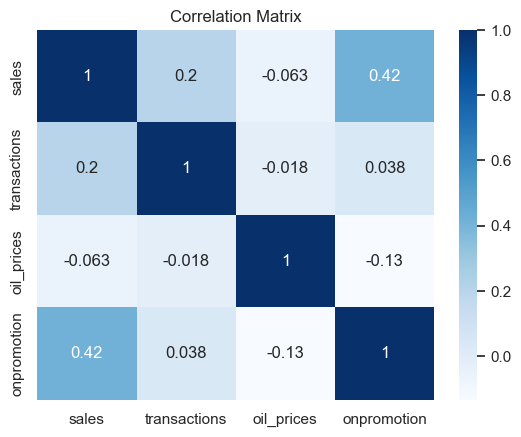

In [550]:
# Select numerical variables for correlation analysis
numerical_vars = ['sales', 'transactions', 'oil_prices','onpromotion']

# Compute correlation matrix
corr_matrix = salesdata[numerical_vars].corr()

# Plot heatmap
sns.heatmap(corr_matrix, annot=True, cmap='Blues')
plt.title('Correlation Matrix')
plt.show()

<div class="alert alert-block alert-danger" style="background-color: #e6ebef;">
    <h4 style="padding: 15px; color: black;">
        There is a significant relationship between number of items on promotion with slaes as well as a week relation with transactions and sales.
    </h4>
</div>


## **5. Testing Hypothesis**

### Before hypothesis testing we explore the distribution of sales.Using shapiro wilk test to explore distribution.

In [555]:
# Group the data by 'Year Funded'
grouped_data = salesdata.groupby('date')['sales'].sum()
grouped_data
# Perform Shapiro-Wilk test for each group
statistic, p_value = stats.shapiro(grouped_data)
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic)
print("P-value:", p_value)
if p_value < 0.05:
    print("The data does not follow a normal distribution.")
else:
    print("The data follows a normal distribution.")

Shapiro-Wilk Test Results:
Statistic: 0.8635020852088928
P-value: 1.2377075926661707e-11
The data does not follow a normal distribution.


<div class="alert alert-block alert-danger" style="background-color: #e6ebef;">
    <h4 style="padding: 15px; color: black;">
        The sales do not follow normal distribution.
    </h4>
</div>


### **The distribution is not normal hence non parametric ANOVA is used.**


### **Hypothesis 1: <br>**
#### ```Null```: The promotional activities, oil prices, and holidays/events do not have a significant impact on store sales for Corporation Favorita.<br>
#### ```Alternate```: The promotional activities, oil prices, and holidays/events have a significant impact on store sales for Corporation Favorita.

>### On promotion .In this we use a scatterplot analysis

<div class="alert alert-block alert-danger" style="background-color: #e6ebef;">
    <h4 style="padding: 15px; color: black;">
        The sales do not follow normal distribution.
    </h4>
</div>


### **Hypothesis 2: <br>**
### ```Null```: Sales increase over time. <br>
### ```Alternate```: Sales dont increase with time.



### **Hypothesis 3: <br>**
### ```Null```: Situating a startup in a particular city does not influence funding.<br>
### ```Alternate```: Situating a startup in a particular city significantly affects funding.



### **Hypothesis 4: <br>**
### ```Null```: The more the transactions the higher the sales. <br>
### ```Alternate```: Transactions don't have an impact on sales.